# Подготовка изображения

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [0]:
img_source = cv2.imread('0.Cells.png')
img = cv2.cvtColor(img_source,cv2.COLOR_BGR2GRAY)

In [0]:
def get_elem(path):
    img = cv2.imread(path)
    elem = np.zeros((img.shape[0], img.shape[1]), dtype='uint8')
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if img[x][y][0] == 0:
                elem[x, y] = 1
    return elem

# 1. Применение водораздела

На вход метода водораздела подается маска-маркер, которая показывает точное местонахождение фона, объектов и области, где надо произвести разграничение водоразделом.

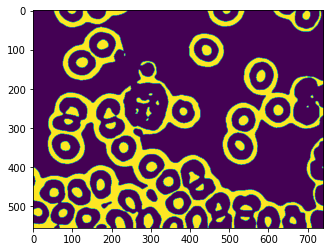

In [768]:
# Бинаризуем картинку и убираем фон
img = cv2.GaussianBlur(img,(9,9),0)
ret3,res = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
cv2.imwrite('1.1.Binary.png',res)
plt.imshow(res)

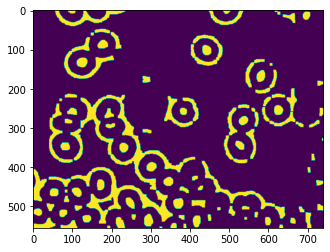

In [167]:
# Очищаем дальше от шума (некоторые клетки разрушились)
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(res,cv2.MORPH_OPEN,kernel, iterations = 3)
cv2.imwrite('1.2.Opening.png', opening)
plt.imshow(opening)

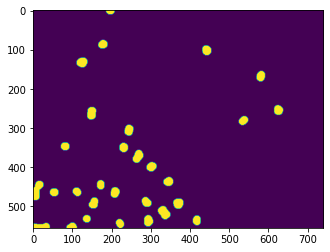

In [168]:
# Маркер, показывающий, где точно находится объект
elem = get_elem('structure_elem.png')
erode = cv2.erode(opening, elem)
sure_fg = cv2.dilate(erode, elem, iterations=1)
cv2.imwrite('1.3.1.ObjectMarker.png', sure_fg)
plt.imshow(sure_fg)

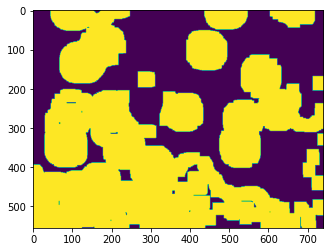

In [169]:
# Маркер, показывающий, где точно находится фон
sure_bg = cv2.dilate(opening,kernel,iterations=12)
cv2.imwrite('1.3.2.BackMarker.png', sure_bg)
plt.imshow(sure_bg)

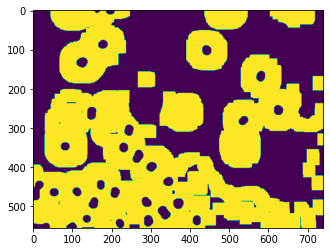

In [170]:
# Выделение неизвестной области
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
cv2.imwrite('1.3.3.UnknownMarker.png', unknown)
plt.imshow(unknown)

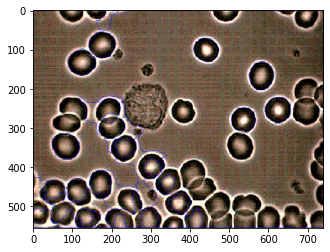

In [171]:
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0
img_water = img_source.copy()
markers = cv2.watershed(img_water,markers)
img_water[markers == -1] = [0,0,255]
cv2.imwrite('1.4.ResultWatershed.png', img_water)
plt.imshow(img_water)

Итог: как мы видим, некоторые клетки выделились правильно, но их очень мало по сравнению с выделением неправильных областей.
Следующей попыткой было поиск окружностей с помощью преобразований Хафа.

# 2. Преобразования Хафа
Сначала поиск окружностей был запущен на полутоновой картинке. Подбор параметров помог более точно показать и подсчитать найденные клетки крови (Результат: 40 клеток)

In [0]:
img = cv2.cvtColor(img_source,cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img,(25,25),0)

In [0]:
circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,45,
                            param1=50,param2=20,minRadius=23,maxRadius=47)

In [0]:
cimg = img.copy()
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

(40, 3)

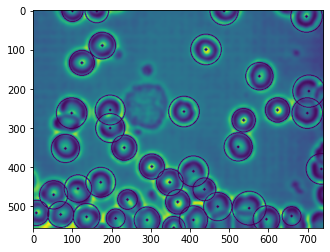

In [375]:
cv2.imwrite('2.1.ResultHougf.png',cimg)
plt.imshow(cimg)
# Найдено клеток:
circles[0].shape

Чтобы избавиться от сильной зависимости "удачных" параметров, был рассмотрен следующий алгоритм:
- С помощью эрозии находим центры клеток крови и расширяем дилатацией и структурным элементом "диск"
- Запускаем поиск окружностей на полученном изображении
- Выводим полученные окружности на исходное полутоновое изображение

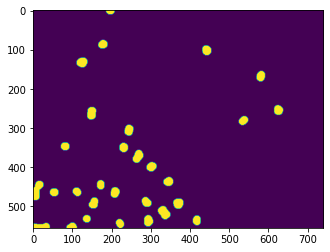

In [90]:
elem = get_elem('structure_elem.png')
erode = cv2.erode(opening, elem)
sure_fg = cv2.dilate(erode, elem, iterations=1)
cv2.imwrite('2.2.1.Centres.png', sure_fg)
plt.imshow(sure_fg)

In [0]:
circles = cv2.HoughCircles(sure_fg,cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=17,minRadius=8,maxRadius=100)

In [0]:
cimg = img.copy()
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

(12, 3)

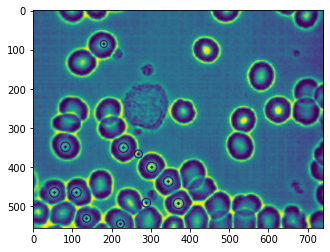

In [93]:
cv2.imwrite('2.2.2.ResultHougfWithErode.png',cimg)
plt.imshow(cimg)
# Найдено клеток:
circles[0].shape

Ответ поиска: 12 клеток. Как мы видим, Хаф находит помимо клеток еще и окружности в фоне. Также не все центры, выделенные эрозией, выделились преобразованиями Хафа, так как центры клеток не идеально круглые и при эрозии на их месте остались неровные участки. При дилатации этих участков образовались не круги, а эллипсы, которые не захватываются поиском окружностей. 

Для дальнейших попыток воспользовались квантованием по яркости

# 3. Выделение клеток квантованием по яркости

Подадим на вход Хафу бинарное изображение, полученное квантованием по яркости исходного изображения. Изображение поделено на три уровня, последний из которых отмечался белым цветом, остальные - черным. 

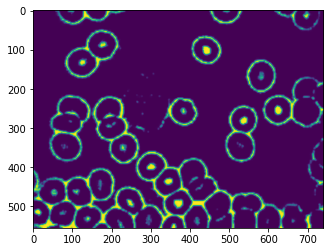

In [922]:
img_quant = cv2.imread('Quant.png')
img1 = cv2.cvtColor(img_quant,cv2.COLOR_BGR2GRAY)
img1 = cv2.GaussianBlur(img1,(7,7),0)
plt.imshow(img1)

In [930]:
ret3,res1 = cv2.threshold(img1,45,255,cv2.THRESH_BINARY)
cv2.imwrite('3.1.ManualBinary.png',res1)


True

In [931]:
circles = cv2.HoughCircles(res1,cv2.HOUGH_GRADIENT,1,51,
                            param1=120,param2=11,minRadius=21,maxRadius=50)
circles.shape

(1, 37, 3)

In [0]:
cimg = img.copy()
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,0,0),2)
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,0),3)

(37, 3)

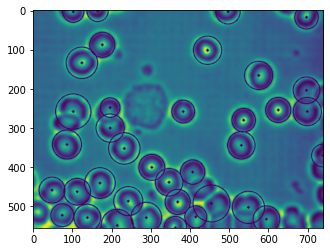

In [933]:
cv2.imwrite('3.2.ResultHougfWithQuant.png',cimg)
plt.imshow(cimg)
# Найдено клеток:
circles[0].shape

В итоге клеток насчитано 37. К сожалению при дальнейшем подборе параметров в сторону уточнения захватывается и шум. Поэтому появилась идея - немного избавиться от шума с помощью маски.  

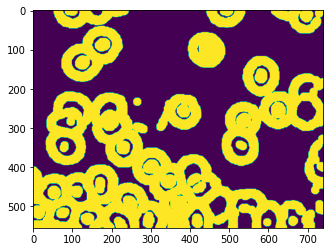

In [934]:
# Избавимся немного от шума
erode = cv2.erode(res, kernel,iterations=1)
dilate = cv2.dilate(erode, kernel, kernel,iterations=1)
# Образуем маску
mask = cv2.dilate(dilate, elem, iterations=1)
cv2.imwrite('3.3.1.Mask.png', mask)
plt.imshow(mask)

True

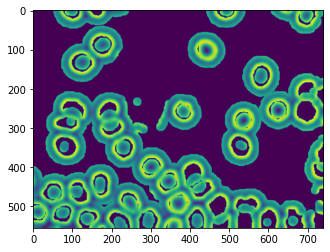

In [935]:
# Перемножаем исходное полутоновое изображение на маску
mult = img * mask
plt.imshow(mult)
cv2.imwrite('3.3.2.MaskResult.png', mult)

In [952]:
circles = cv2.HoughCircles(mult,cv2.HOUGH_GRADIENT,1,51,
                            param1=150,param2=13,minRadius=22,maxRadius=40)
circles.shape

(1, 40, 3)

In [0]:
cimg = img.copy()
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

(40, 3)

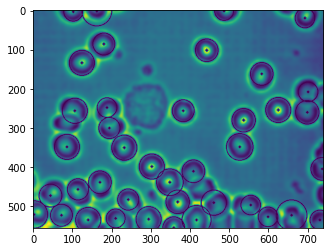

In [954]:
cv2.imwrite('3.4.3.ResultHougfWithMask.png',cimg)
plt.imshow(cimg)
# Найдено клеток:
circles[0].shape

В итоге получено 40 клеток - лучше, чем результат применения преобразований Хафа к поделенному на уровни изображению без маски, но такой же как применение преобразований Хафа к исходному полутоновому изображению.

Как можно увидеть - в зависимости от того, что было подано на вход и какими приемами пользовались, большинство клеток крови находятся Хафом в любом случае, однако некоторые из них определяются в одном подходе без проблем, в другом - не выделяются на изображении

Также для этого проекта применялось выделение контуров на исходном полутоновом изображении и на бинаризованных с помощью метода Оцу и квантования по яркости. Однако полученный результат после выделения нельзя было применять дальше. 